Quero minimizar

$$
Q( \beta) = g(\beta)' \big[ \Omega( \beta) \big]^{-1} g(\beta) 
$$

Para escrever no formato de razão de polinômios, uso a identidade $A^{-1} = |A|^{-1} A^*$, em que $A^*$ é a matriz adjunta de A. Tenho então

$$
Q( \beta) = \frac{g(\beta)'\Omega^*( \beta)g(\beta) }{   | \Omega(\beta) | } = \frac{p(\beta)}{ q(\beta) }
$$

In [1]:
using Pkg
using LinearAlgebra
using Symbolics
using MultivariatePolynomials
using DynamicPolynomials
using HomotopyContinuation             # para plots
using Distributions
using Random
using Plots  

# Função que arredonda polinômios

function roundp(p)
      if p isa AbstractPolynomialLike
          cs = coefficients(p)
          ms = monomials(p)
          return isempty(cs) ? zero(p) : sum(round(c; digits=1) * m for (c, m) in zip(cs, ms))
      elseif p isa Number
          return round(p; digits=2)
      elseif p isa AbstractArray
          return map(roundp, p)
      else
          error("Unsupported type in roundp: $(typeof(p))")
      end
  end
  # -----


function adj(A::AbstractMatrix)
n, m = size(A)
@assert n == m "adjugate requer matriz quadrada"
C = Matrix{eltype(A)}(undef, n, n)  # matriz de cofatores
idx = collect(1:n)
for i in 1:n, j in 1:n
    r = idx[idx .!= i]
    c = idx[idx .!= j]
    C[i, j] = ((-1)^(i + j)) * det(A[r, c])   # cofactor(i,j)
end
return transpose(C)  # adj(A) = cof(A)'
end  ;

function expand_vector(v) 
    return [ModelKit.expand(v[i]) for i in 1:length(v)] end 

expand_vector (generic function with 1 method)

In [2]:

# Parâmetros:

n = 1000
k = 2

Random.seed!(126)

X = rand(n, k)
beta_0 = [3,2]


y = X* beta_0 + rand(Normal(0,1), n) ; 

In [ ]:
@var β[1:k] λ s

g_n = X'*(y - X*β) 

Ω =  sum( ( y[i] - X[i,:]'*β)^2 *  X[i,:]*X[i,:]' for i in 1:n  ) 


p = g_n' * adj(Ω) * g_n
q = det(Ω)

h = β[1]^2 - β[2]^3 


∇h = [ differentiate(h, β[i]) for i in 1:k]
∇p = [ differentiate(p, β[i]) for i in 1:k]
∇q = [ differentiate(q, β[i]) for i in 1:k] ; 



In [4]:
eqA =   expand_vector( q*∇p - p *∇q )  


F = vec( eqA  ) 
vars =  β  
F_sys = System(F; variables=vars)

result = solve(F_sys ; start_system = :total_degree)

complex_sols_unr = solutions(result);

Tracking 49 paths... 100%|██████████████████████████████| Time: 0:00:08
                   # paths tracked: 49
   # non-singular solutions (real): 43 (5)
       # singular endpoints (real): 0 (0)
          # total solutions (real): 43 (5)


In [5]:
eqA =  expand_vector(  q*∇p - p *∇q + λ* (q^2)* ∇h  )     # precisei impor que a slack variable é = 0
eqB = h 
eqC = λ * h


F = vec( [eqA ; eqB ; eqC] ) 

vars = [ β ; λ  ]


F_sys = System(F; variables=vars)


result = solve(F_sys ; start_system = :total_degree)

complex_sols_res = solutions(result)


Tracking 440 paths... 100%|█████████████████████████████| Time: 0:00:07
                   # paths tracked: 440
   # non-singular solutions (real): 14 (1)
       # singular endpoints (real): 17 (2)
          # total solutions (real): 31 (3)


14-element Vector{Vector{ComplexF64}}:
 [2.8198030945693153 + 1.2247322004138328im, 2.0358893022305415 + 0.5703940007520608im, -133.16079200149443 - 124.70027662371969im]
 [2.3892042065331762 - 3.506677416195126im, 0.3264462063400881 + 2.6005790410341114im, 1.3729267221666033 + 0.14694559025155146im]
 [3.022745369552533 + 1.3424632899598317im, 2.1342576355343565 + 0.6105641243358009im, -45.38206858226378 - 26.843380845926657im]
 [6.804782592002061 - 3.2678098685901293im, -0.8590364853030871 + 3.751024450427496im, 0.06425130357902238 + 0.6530374265133414im]
 [4.7306022779443495 - 1.6108676622402542im, -0.8771815730562273 + 2.7882588718214323im, 0.5774279493462536 + 1.3293927566745387im]
 [6.804782592002061 + 3.2678098685901293im, -0.8590364853030871 - 3.751024450427496im, 0.06425130357902238 - 0.6530374265133414im]
 [4.633213461857238 + 6.543349812503365im, 0.45109036587086027 - 3.9803892568500836im, -0.3333293865363502 + 0.12981429270409078im]
 [0.24542368119993818 + 0.9236038218644159

In [6]:
tol = 0.001  # tolerância
display( count(u -> all(abs.(imag.(u)) .< tol), complex_sols_res) ) # 1 solução real no problema restrito
display( count(u -> all(abs.(imag.(u)) .< tol), complex_sols_unr) ) # 3 soluções reais no problema irrestrito

S_res = [ real(s) for s in complex_sols_res if all(abs.(imag.(s)) .< tol)]
S_unr = [real(s) for s in complex_sols_unr if all(abs.(imag.(s)) .< tol)]

  

1

5

5-element Vector{Vector{Float64}}:
 [3.087327129528022, 1.8973945597163437]
 [-186.1001560443376, 135.4860301036905]
 [-37.11590496451934, 67.87236773630138]
 [148.94913244000895, 135.4660526567037]
 [-93.75110105007442, 88.76189518616144]

In [7]:
function Q(b)
   
    g = X'*(y - X*b) 

    Omega =  sum( ( y[i] - X[i,:]'*b)^2 *  X[i,:]*X[i,:]' for i in 1:n  ) 

    return  log( g' * inv( Omega) * g ) 
end    


function H(b)
    return  b[1]^2 - b[2]^3
end   

opt_res =   S_res[ argmin( [ Q([x[1], x[2] ]) for x in S_res ]   ) ][1:2]
opt_unr =   S_unr[ argmin( [ Q([x[1], x[2] ]) for x in S_unr ]   ) ][1:2] 


display(  opt_res  )
display(  opt_unr  )

2-element Vector{Float64}:
 2.9496844984257082
 2.056760440563441

2-element Vector{Float64}:
 3.087327129528022
 1.8973945597163437

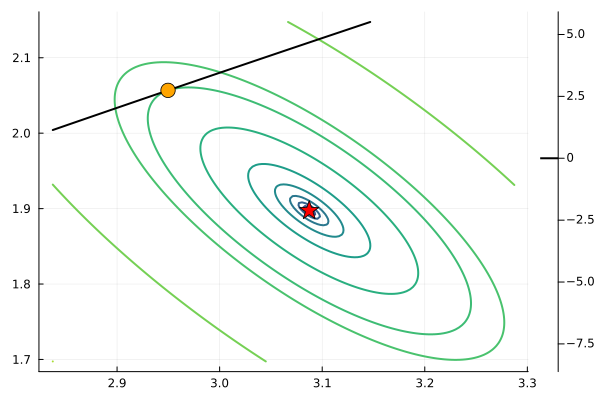

┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different levels share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with different line color share a colorbar.
│ Colorbar may not reflect all series correctly.
└ @ Plots C:\Users\YURI\.julia\packages\Plots\xKhUG\src\backends\gr.jl:530
┌ Warning: Multiple series with differe

In [10]:
# intervalos
x_grid = [ opt_unr[1] + i for i in -0.25: 0.003 :0.2 ]
y_grid = [ opt_unr[2] + i for i in -0.2: 0.003: 0.25 ]     

# grade
Z = [Q([xi, yi]) for yi in y_grid, xi in x_grid]
Z2 = [H([xi, yi]) for yi in y_grid, xi in x_grid]

L = range(minimum(Z), maximum(Z), length=12) 
L = sort(vcat(collect(L), [Q(  [ opt_res[1], opt_res[2]  ] )]))  #adiciona a curva de nível do ótimo restrito

# plota curvas de nível
contour(x_grid, y_grid, Z, levels= L, colormap = :viridis, linewidth=2)

# ponto a destacar
contour!(x_grid, y_grid, Z2, levels=[0], color=:black, linewidth=2, label="x² - y³ = 0")

scatter!([opt_res[1]], [opt_res[2]], color=:orange, markersize=8, label="")
scatter!([opt_unr[1]], [opt_unr[2]], color=:red, markersize=10, label="" , marker =:star5)